<a href="https://colab.research.google.com/github/uyan21/deepLearningStudy/blob/main/deepLearning_stock1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

딥러닝으로 주식단타 예측이 가능한가

In [ ]:
#주가 정보 크롤링을 위해서 url 입력
code="195990"
url="https://finance.naver.com/item/sise_day.nhn?code="+code

import requests
from bs4 import BeautifulSoup
from openpyxl import Workbook
import pandas as pd
import matplotlib.pyplot as plt
#엑셀에 따로쓰기 위함
wb=Workbook()
ws=wb.active

In [ ]:
#1~129페이지 까지 긁는다
#액면 분할 이후 데이터 취급 주의
for i in range(1,130):
  tmplist=[]
  tmp=0
  source=requests.get(url+"&page="+str(i)).text

  soup=BeautifulSoup(source,"html.parser")
  html=soup.select("table.type2")
  for t in html:
    text=t.get_text().replace("\t","")
    while "\n\n" in text:
      text=text.replace("\n\n","\n")
  text=text[1:]
  textlist=text.split("\n")
  if i>1:
    textlist=textlist[7:]

  for t in textlist:
    tmplist.append(t)
    tmp+=1
    if tmp>6:
      print(tmplist)
      ws.append(tmplist)
      tmplist=[]
      tmp=0
  print(i)
  wb.save("drive/MyDrive/stock1.xlsx")

In [ ]:
#크롤링한 엑셀 데이터 읽어옴
df=pd.read_excel("drive/MyDrive/stock1.xlsx")
print(df['종가'])

0        2,625
1        2,660
2        2,735
3        3,000
4        3,000
         ...  
1285    16,050
1286    16,900
1287    17,000
1288    16,900
1289    16,800
Name: 종가, Length: 1290, dtype: object


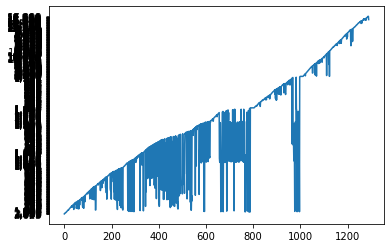

In [ ]:
#종가 데이터 그래프 출력(정규화 필요함)
plt.plot(df['종가'])
plt.show()

In [ ]:
#정규화를 위해 ,빼고 문자열 float으로 형변환
df=pd.read_excel("drive/MyDrive/stock1.xlsx")
for i in range(1,7):
  df.iloc[:,i]=df.iloc[:,i].str.replace(pat=',', repl='', regex=False)
df.iloc[:,1:]=df.iloc[:,1:].astype(float)

In [ ]:
#확인
df.iloc[:,1]

0        2625
1        2660
2        2735
3        3000
4        3000
        ...  
1285    16050
1286    16900
1287    17000
1288    16900
1289    16800
Name: 종가, Length: 1290, dtype: object

In [ ]:
#날짜를 제외한 모든 데이터 정규화(nomalization)
for k in range(1,7):
  for i in range(len(df.iloc[:,1])):
    df.iloc[:,k][i]=(df.iloc[:,k][i]-min(df.iloc[:,k]))/(max(df.iloc[:,k])-min(df.iloc[:,k]))
print(df.iloc[:,0:])

              날짜        종가        전일비        시가        고가        저가       거래량
0     2020.11.30  0.138649  0.0162791  0.148991   0.15779  0.151632  0.125933
1     2020.11.27  0.155549  0.0348837  0.145821  0.164306  0.139763  0.586758
2     2020.11.26  0.159935   0.123256  0.185879  0.192635  0.145697  0.699067
3     2020.11.25  0.175432          0         0         0         0         0
4     2020.11.24  0.175432  0.0534884   0.17464  0.190368  0.161424  0.699731
...          ...       ...        ...       ...       ...       ...       ...
1285  2015.09.04  0.944118          1  0.976945  0.963173  0.937685  0.768335
1286  2015.09.03  0.994118   0.285714  0.988473         1         1  0.543604
1287  2015.09.02         1   0.285714  0.948127  0.974432  0.973294  0.481761
1288  2015.09.01         1   0.285714         1         1         1         1
1289  2015.08.31         1          1         1         1         1         1

[1290 rows x 7 columns]


In [ ]:
#전일비와 날짜는 쓸모없는 칼럼이므로 날린다
del df['전일비']
del df['날짜']
print(df)

            종가        시가        고가        저가       거래량
0     0.138649  0.148991   0.15779  0.151632  0.125933
1     0.155549  0.145821  0.164306  0.139763  0.586758
2     0.159935  0.185879  0.192635  0.145697  0.699067
3     0.175432         0         0         0         0
4     0.175432   0.17464  0.190368  0.161424  0.699731
...        ...       ...       ...       ...       ...
1285  0.944118  0.976945  0.963173  0.937685  0.768335
1286  0.994118  0.988473         1         1  0.543604
1287         1  0.948127  0.974432  0.973294  0.481761
1288         1         1         1         1         1
1289         1         1         1         1         1

[1290 rows x 5 columns]


In [ ]:
#텐서플로우, 케라스 넘파이 임포트
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import numpy as np

In [ ]:
#데이터를 한칸씩 밀어서 다음날 종가를 추론 할수있게 한다
x_train=df[:999].drop(['종가'],axis='columns')
y_train=df[1:1000]['종가']
x_train=np.array(x_train).astype(np.float32)
y_train=np.array(y_train).astype(np.float32)
x_train=x_train.reshape(x_train.shape[0],4,1)
x_test=df[999:1289].drop(['종가'],axis='columns')
y_test=df[1000:]['종가']
x_test=np.array(x_test).astype(np.float32)
y_test=np.array(y_test).astype(np.float32)
x_test=x_test.reshape(x_test.shape[0],4,1)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_train,y_train)

In [ ]:
#실제로 매칭이 되나 확인
print(x_train[0],y_train[0])

[[0.14899136]
 [0.15779036]
 [0.15163204]
 [0.12593286]] 0.1555487


In [ ]:
#레이어 모델을 쌓는다.
model = Sequential()

model.add(LSTM(64,
    input_shape=(4,1),
    return_sequences=True))

model.add(LSTM(
    64,
    return_sequences=False))
model.add(Dense(1,Activation('linear')))

model.compile(loss='mse', optimizer='rmsprop',metrics=["accuracy"])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4, 64)             16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#학습시작
model.fit(x_train,y_train,epochs=10,batch_size=4)

Epoch 1/10
250/250 [==============================] - 1s 6ms/step - loss: 4.3874e-04 - accuracy: 0.0000e+00
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 3.3157e-04 - accuracy: 0.0000e+00
Epoch 3/10
250/250 [==============================] - 2s 6ms/step - loss: 3.3146e-04 - accuracy: 0.0000e+00
Epoch 4/10
250/250 [==============================] - 1s 5ms/step - loss: 2.9933e-04 - accuracy: 0.0000e+00
Epoch 5/10
250/250 [==============================] - 1s 5ms/step - loss: 3.0641e-04 - accuracy: 0.0000e+00
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 2.8508e-04 - accuracy: 0.0000e+00
Epoch 7/10
250/250 [==============================] - 1s 5ms/step - loss: 2.7433e-04 - accuracy: 0.0000e+00
Epoch 8/10
250/250 [==============================] - 1s 5ms/step - loss: 2.8006e-04 - accuracy: 0.0000e+00
Epoch 9/10
250/250 [==============================] - 1s 5ms/step - loss: 2.9241e-04 - accuracy: 0.0000e+00
Epoch 10/10
250/250 [=======

In [ ]:
#추이를 확인한다 정확성은 무시
model.evaluate(x_test,y_test)

10/10 [==============================] - 0s 2ms/step - loss: 0.1081 - accuracy: 0.0172


[0.10813123732805252, 0.017241379246115685]

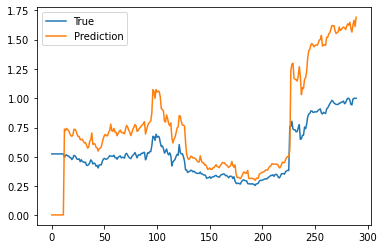

In [ ]:
#뒤에 자른 데이터와 그래프로 비교한다
pred=model.predict(x_test)
fig=plt.figure(facecolor='white')
ax=fig.add_subplot(111)
ax.plot(y_test,label='True')
ax.plot(pred,label='Prediction')
ax.legend()
plt.show()

In [ ]:
print(x_train,y_train)